<a href="https://colab.research.google.com/github/MaxTechniche/DS20_Unit_1_Build/blob/master/Jacob_Maxfield_Unit_1_Project_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMDb Top 250 List**

###### Imports

In [1]:
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from collections import defaultdict

##### Gather Datasets (Web Scraping)

###### Functions (I've already preprocessed it below.)

In [2]:
def convert_runtime(time):
  """Converts a string movie runningtime "#h ##min" to a int of total minutes."""
  runtime = time.split()
  print(runtime)
  if len(runtime) > 1:
    hours = int(runtime[0][:-1])
    minutes = int(runtime[1][:-3])
  elif len(runtime) == 1:
    if runtime[0][-1:] == 'h':
      hours = int(runtime[0][:-1])
      minutes = 0
    else:
      minutes = int(runtime[0][:-3])
      hours = 0
  else:
    return None
  converted_time = hours * 60 + minutes

  return converted_time

def get_imdb_top_250():
  """Gets list of the top 250 IMDb movies Titles and IDs. Returns a dictionary."""
  t_url = "https://www.imdb.com/chart/top"
  source = requests.get(t_url).text
  soup = BeautifulSoup(source, 'html.parser')

  movie_links = soup.find('tbody', class_='lister-list').find_all('a')
  movie_titles = {title['href'][9:-1]:title.text for title in movie_links}
  return movie_titles

def movie_info(df):
  """Gets list of the top 250 IMDb movies extended info. Returns a dictionary."""
  imdb = "https://www.imdb.com/"
  movie_info = defaultdict(dict)

  for id in df['ID']:
    source = requests.get(imdb + 'title/tt' + id).text
    info = BeautifulSoup(source, 'lxml').find('div', class_='subtext')

    rating = info.next_element.strip()

    runtime = convert_runtime(info.time.text.strip())

    try:
      genres = ', '.join([genre.text.strip() for genre in info.find_all(href=re.compile('/search'))])
    except AttributeError:
      genres = None

    try:
      release_date = info.find(href=re.compile('/title/tt')).text.strip()
      release_country = re.search('\([\w ]+\)', release_date)
      if release_country:
        release_country = release_country.group(0)
        release_date = release_date.strip(release_country).strip()
        release_country = release_country.lstrip('(').rstrip(')')
    except AttributeError:
      release_date = None
      release_country = None
    for name, val in zip(['Rating', 'Runtime', 'Genres', 'Release_Date', 'Release_Country'], [rating, runtime, genres, release_date, release_country]):
      movie_info[id][name] = val
  return movie_info
  
def merge_title_data():
  movie_titles = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/top_250_imdb_list.csv'
  extended_movie_info = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/top_250_movies_info.csv'

  df_titles = pd.read_csv(movie_titles)
  df_info = pd.read_csv(extended_movie_info)

  df = pd.merge(df_titles, df_info, on='ID')
  df.to_csv('top_250_IMDb_movies.csv', index=False)
  return pd.read_csv('top_250_IMDb_movies.csv')

def get_int(comma_num):
  return int(''.join(comma_num.split(',')))

def get_rankings(df):
  rankings_dict = defaultdict(dict)
  rank_names = [
      *[str(x) for x in range(10, 0, -1)],
      *['Rank_' + gender + star for gender in ['All_', 'Male_', 'Female_'] for star in ['All_Ages','<18','18-29','30-44','45+']],
      *['Count_' + gender + count for gender in ['All_', 'Male_', 'Female_'] for count in ['All_Ages','<18','18-29','30-44','45+']]]
  
  title_link = 'https://www.imdb.com/title/tt'
  ids = df['ID']

  for id in ids:
    search = title_link + id + 'ratings'
    page = BeautifulSoup(requests.get(search).text, 'lxml')

    rank_values = []

    # Total Stars
    rank_values.extend([get_int(r.text.strip()) for r in page.find_all('div', class_='leftAligned')[1:11]])
    rank_values.extend([float(r.text.strip()) for r in page.find_all('div', class_='bigcell')[:15]])
    rank_values.extend([get_int(r.text.strip()) for r in page.findAll('a', href=re.compile('/title/tt' + id + 'ratings\?demo'))[:15]])
    
    for name, val in zip(rank_names, rank_values):
      rankings_dict[id][name] = val
  ranks = pd.DataFrame.from_dict(rankings_dict).T
  ranks.reset_index().rename({'index':'ID'}, axis=1).to_csv('top_250_rankings.csv', index=False)
  return pd.read_csv('top_250_rankings.csv')


###### Do not uncomment!

In [3]:
# imdb = "https://www.imdb.com/"

# titles = imdb_top_titles()
# df = pd.DataFrame.from_dict(data=movie_info(titles, imdb)).T
# df = df.reset_index().rename(columns={'index':'ID'})

# df = merge_title_data()

# Full Movie Titles link
# movies_link = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/top_250_IMDb_movies.csv'
# df = pd.read_csv(movies_link)

# rankings = get_rankings(df)
# df = pd.merge(df, rankings, on='ID')
# df.to_csv('top_250_IMDb_movies_and_rankings.csv', index=False)
# df = pd.read_csv('top_250_IMDb_movies_and_rankings.csv')

# Start here:

In [4]:
imdb_list = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/top_250_IMDb_movies_and_rankings.csv'
df = pd.read_csv(imdb_list)
df

,ID,Title_Name,Year,Rating,Runtime,Genres,Release_Date,Release_Country,10,9,8,7,6,5,4,3,2,1,Rank_All_All_Ages,Rank_All_<18,Rank_All_18-29,Rank_All_30-44,Rank_All_45+,Rank_Male_All_Ages,Rank_Male_<18,Rank_Male_18-29,Rank_Male_30-44,Rank_Male_45+,Rank_Female_All_Ages,Rank_Female_<18,Rank_Female_18-29,Rank_Female_30-44,Rank_Female_45+,Count_All_All_Ages,Count_All_<18,Count_All_18-29,Count_All_30-44,Count_All_45+,Count_Male_All_Ages,Count_Male_<18,Count_Male_18-29,Count_Male_30-44,Count_Male_45+,Count_Female_All_Ages,Count_Female_<18,Count_Female_18-29,Count_Female_30-44,Count_Female_45+
0,0111161/,The Shawshank Redemption,1994,R,142,Drama,14 October 1994,USA,1262354.0,583880.0,265474.0,85024.0,25611.0,13192.0,6428.0,4628.0,4312.0,34201.0,9.3,9.3,9.3,9.3,9.1,9.3,9.3,9.3,9.3,9.1,9.2,9.0,9.2,9.2,9.2,2285104.0,1859.0,487165.0,867022.0,205233.0,1394422.0,1308.0,387767.0,724633.0,166576.0,274622.0,259.0,88180.0,129811.0,34510.0
1,0068646/,The Godfather,1972,R,175,"Crime, Drama",24 March 1972,USA,815469.0,390277.0,192975.0,76283.0,29274.0,16195.0,8248.0,6133.0,5799.0,36698.0,9.2,9.2,9.2,9.2,9.1,9.2,9.2,9.3,9.2,9.2,8.9,8.8,8.9,8.9,8.9,1577351.0,1178.0,310646.0,621830.0,160127.0,1006212.0,851.0,259481.0,538999.0,133895.0,152074.0,155.0,44131.0,74072.0,23038.0
2,0071562/,The Godfather: Part II,1974,R,202,"Crime, Drama",18 December 1974,USA,474065.0,315817.0,170707.0,68952.0,25735.0,12383.0,6081.0,4273.0,3841.0,20194.0,9.0,9.1,9.0,9.0,8.9,9.0,9.1,9.1,9.0,9.0,8.7,9.0,8.8,8.7,8.7,1102048.0,700.0,207660.0,437435.0,119462.0,713710.0,518.0,178064.0,383327.0,100765.0,96294.0,101.0,25330.0,47896.0,16400.0
3,0468569/,The Dark Knight,2008,PG-13,152,"Action, Crime, Drama",18 July 2008,USA,1010114.0,631933.0,345435.0,134595.0,48559.0,22780.0,11238.0,7970.0,7077.0,30045.0,9.0,9.2,9.2,9.0,8.4,9.1,9.2,9.3,9.0,8.4,8.7,8.8,8.8,8.7,8.2,2249746.0,2039.0,519664.0,883542.0,146568.0,1411141.0,1507.0,420381.0,746893.0,123426.0,251133.0,216.0,87683.0,124540.0,20271.0
4,0050083/,12 Angry Men,1957,Approved,96,"Crime, Drama",10 April 1957,USA,238674.0,219032.0,130270.0,47180.0,15489.0,6143.0,2823.0,1680.0,1461.0,8172.0,8.9,9.1,9.1,8.9,8.7,9.0,9.2,9.1,8.9,8.7,8.8,8.5,8.9,8.8,8.7,670924.0,583.0,148257.0,246713.0,67702.0,419208.0,437.0,122266.0,211856.0,56882.0,69330.0,74.0,23215.0,31869.0,9632.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0088247/,The Terminator,1984,R,107,"Action, Sci-Fi",26 October 1984,USA,114809.0,158924.0,278749.0,155130.0,47473.0,15702.0,6112.0,3190.0,2148.0,4082.0,8.0,8.1,7.9,8.0,8.2,8.1,8.1,7.9,8.1,8.3,7.7,8.2,7.5,7.7,8.0,786319.0,500.0,129901.0,337992.0,95037.0,525656.0,402.0,113312.0,298154.0,81232.0,66670.0,54.0,14718.0,35655.0,12274.0
246,10431500/,Yedinci Kogustaki Mucize,2019,NaN,132,Drama,11 October 2019,Turkey,10158.0,6668.0,6532.0,3346.0,1300.0,538.0,246.0,144.0,100.0,317.0,8.3,8.6,8.3,8.2,8.0,8.2,8.3,8.2,8.1,8.0,8.5,9.0,8.5,8.4,8.3,29349.0,92.0,7580.0,8455.0,1257.0,14920.0,58.0,5088.0,6703.0,1034.0,4062.0,16.0,1936.0,1423.0,182.0
247,0111495/,Three Colors: Red,1994,R,99,"Drama, Mystery, Romance",23 November 1994,USA,17426.0,19183.0,26553.0,14016.0,4868.0,2111.0,942.0,583.0,507.0,1931.0,8.1,8.2,8.3,8.0,7.9,8.0,8.6,8.3,8.0,7.9,8.0,7.4,8.2,8.0,8.0,88120.0,46.0,14151.0,36183.0,15192.0,54716.0,28.0,10863.0,29291.0,12609.0,12479.0,15.0,3090.0,6482.0,2373.0
248,5323662/,A Silent Voice: The Movie,2016,Not Rated,130,"Animation, Drama, Family",17 September 2016,Japan,10726.0,9927.0,10619.0,6048.0,2360.0,862.0,372.0,188.0,131.0,302.0,8.1,8.4,8.3,7.8,7.6,8.1,8.4,8.3,7.9,7.6,8.0,8.2,8.0,7.8,7.6,41535.0,205.0,12950.0,8105.0,1163.0,20212.0,132.0,9656.0,6574.0,959.0,5166.0,41.0,2848.0,1375.0,172.0


In [5]:
df['Release_Date'][51] = 'September 1954'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
df['Release_Date'].value_counts()

14 October 1994     2
28 March 2003       2
25 June 1982        2
15 November 2019    2
22 November 1995    2
                   ..
23 February 1996    1
7 January 1947      1
7 April 2017        1
19 December 1997    1
10 January 2020     1
Name: Release_Date, Length: 245, dtype: int64

**SAME DAY RELEASES?!**

In [7]:
df['Release_Date'] = pd.to_datetime(df['Release_Date'])

In [8]:
rd_pairs = df[df['Release_Date'].isin(df['Release_Date'].value_counts().head(5).index)]
rd_pairs = rd_pairs.sort_values(['Release_Date', 'Rank_All_All_Ages'])

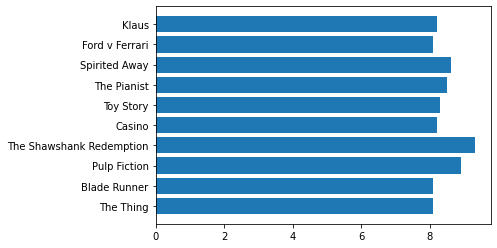

In [9]:
plt.barh(rd_pairs['Title_Name'], rd_pairs['Rank_All_All_Ages'],)
plt.show()

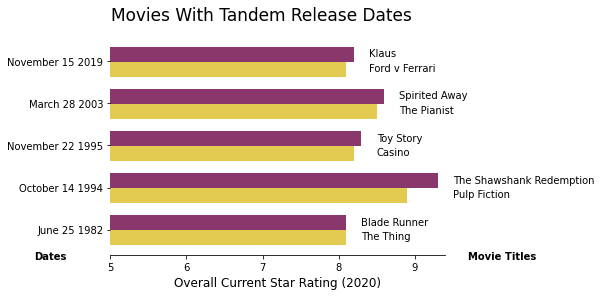

In [10]:
barHeight = 0.35

ranks1 = rd_pairs['Rank_All_All_Ages'][::2]
ranks2 = rd_pairs['Rank_All_All_Ages'][1::2]

names1 = rd_pairs['Title_Name'][::2]
names2 = rd_pairs['Title_Name'][1::2]

bar1 = np.arange(len(ranks1)) -.19
bar2 = [y + barHeight for y in bar1]

plt.barh(bar1, ranks1, barHeight, color='#E3CB51')
plt.barh(bar2, ranks2, barHeight, color='#89376D')

plt.yticks(bar1+.19, [' '.join([d.month_name(), str(d.day), str(d.year)]) for d in pd.Series(rd_pairs['Release_Date'].unique())])
plt.xticks(range(5, 11))

plt.xlabel('Overall Current Star Rating (2020)',size=12)

plt.title('Movies With Tandem Release Dates', x=.45, y=1.05, size=17)

for x, y, name in zip([*ranks2, *ranks2], [*bar1, *bar2], [*rd_pairs['Title_Name'][::2], *rd_pairs['Title_Name'][1::2]]):
  plt.text(x+.2, y-.05, name)

for spine in ['right', 'top', 'left']:
  plt.gca().spines[spine].set_visible(False)

plt.text(4, -.7, 'Dates',weight='bold')
plt.text(9.7, -.7, 'Movie Titles', weight='bold')

plt.xlim(5, 9.4)

plt.show()